In [ ]:
pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 62.7 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.57
    Uninstalling yfinance-0.2.57:
      Successfully uninstalled yfinance-0.2.57


In [ ]:
"""
This program forecasts the USD/ZAR currency exchange rate using data from the Yahoo database.
It evaluates four models—ANN, RNN, LSTM, and GRU—comparing their performance.
The results are analyzed and discussed based on the efficiency of each model.
"""
import yfinance as yf #import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU

import keras.backend as K
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

                                Open       High        Low      Close  Volume  \
Date                                                                            
2010-01-01 00:00:00+00:00   7.340500   7.340500   7.340200   7.340200       0   
2010-01-04 00:00:00+00:00   7.394800   7.463100   7.257600   7.264900       0   
2010-01-05 00:00:00+00:00   7.281700   7.334500   7.229400   7.301900       0   
2010-01-06 00:00:00+00:00   7.301900   7.367000   7.269300   7.302200       0   
2010-01-07 00:00:00+00:00   7.288800   7.442200   7.267700   7.424100       0   
...                              ...        ...        ...        ...     ...   
2025-04-28 00:00:00+01:00  18.682489  18.746401  18.517349  18.682489       0   
2025-04-29 00:00:00+01:00  18.494499  18.585711  18.462601  18.494499       0   
2025-04-30 00:00:00+01:00  18.513201  18.654400  18.501089  18.513201       0   
2025-05-01 00:00:00+01:00  18.538980  18.704000  18.571899  18.538980       0   
2025-05-02 00:00:00+01:00  1

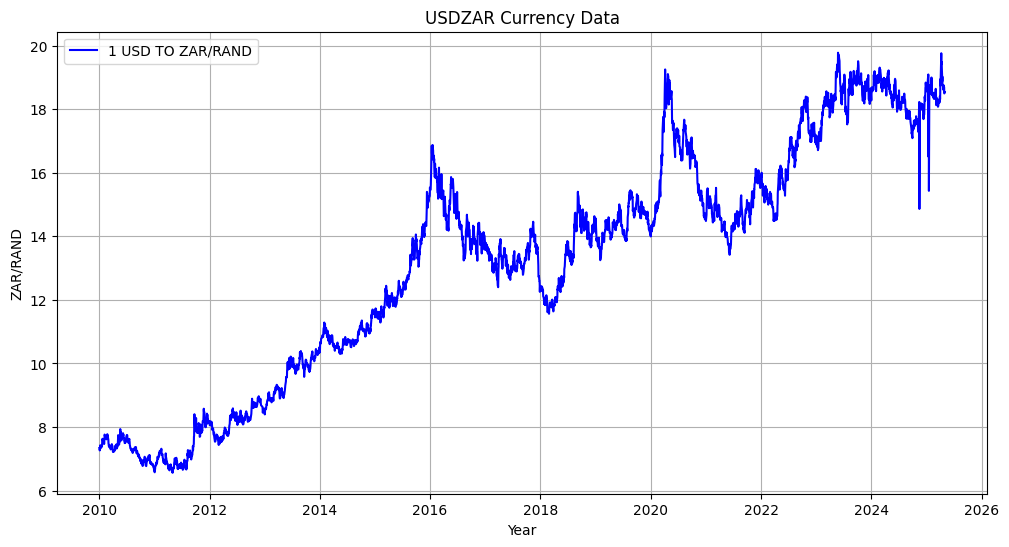

In [ ]:
start_date = '2010-01-01'  #extract the data from the yfinace
end_date = '2025-05-05'
df = yf.Ticker('USDZAR=X').history(start=start_date, end=end_date)
#df = yf.download('USDZAR=X', start=start_date, end=end_date, auto_adjust=False, progress=False, threads=False)
#df = yf.download('USDZAR=X', start=start_date, end=end_date,  auto_adjust=False)

print(df)  #display the data
plt.figure(figsize=(12, 6)) #plot the data
plt.plot(df.index, df['Close'], label='1 USD TO ZAR/RAND', color='b')
plt.title('USDZAR Currency Data')
plt.xlabel('Year')
plt.ylabel('ZAR/RAND')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print('Statistics Data----------------------------------------------------------------')
print(df.describe())  #display the data

Statistics Data----------------------------------------------------------------
              Open         High          Low        Close  Volume  Dividends  \
count  3991.000000  3991.000000  3991.000000  3991.000000  3991.0     3991.0   
mean     13.182088    13.282841    13.097987    13.182347     0.0        0.0   
std       3.713196     3.744468     3.686495     3.712933     0.0        0.0   
min       6.547700     6.604500     6.523000     6.563000     0.0        0.0   
25%      10.210000    10.280160    10.153770    10.208150     0.0        0.0   
50%      13.841650    13.942580    13.729200    13.839100     0.0        0.0   
75%      15.783150    15.928085    15.666680    15.791800     0.0        0.0   
max      19.774500    19.928499    19.658899    19.774500     0.0        0.0   

       Stock Splits  
count        3991.0  
mean            0.0  
std             0.0  
min             0.0  
25%             0.0  
50%             0.0  
75%             0.0  
max             0.0  


In [ ]:
data = df[['Close']]  #Use the "Close" price
scaler = MinMaxScaler(feature_range=(0, 1)) #scales the data using 0 as min and 1 as max
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data, columns=['Close'])
print(scaled_df)

         Close
0     0.058828
1     0.053128
2     0.055929
3     0.055951
4     0.065178
...        ...
3986  0.917344
3987  0.903115
3988  0.904530
3989  0.906482
3990  0.906612

[3991 rows x 1 columns]


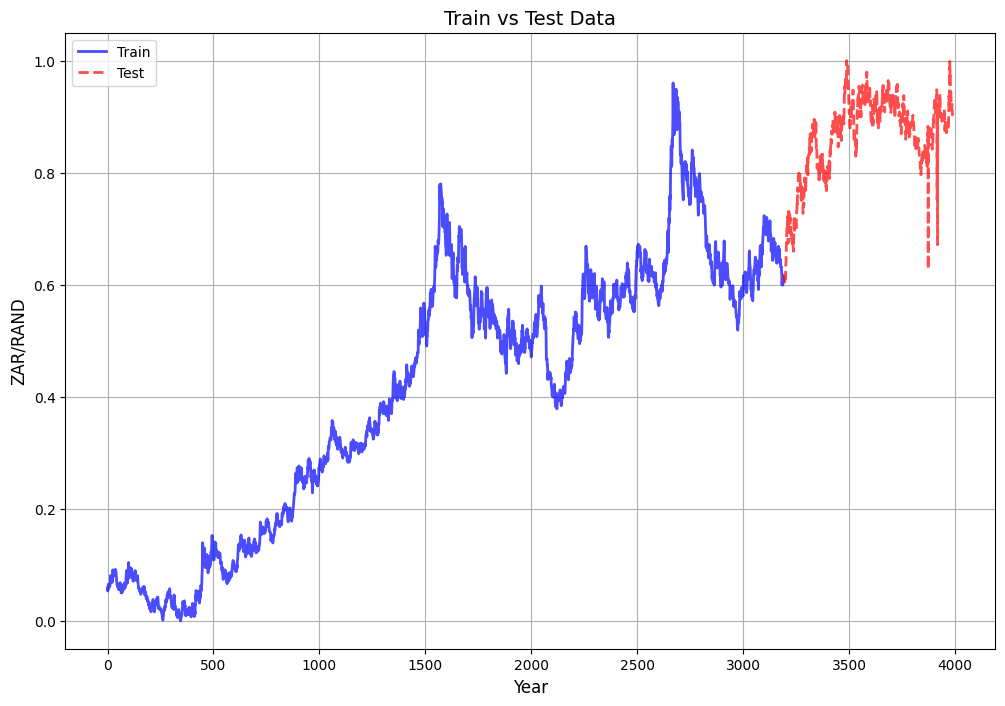

In [ ]:
"""
Divide the dataset using an 80%-20% split to maintain a balanced model, reducing
the risks of overfitting and underfitting. The 80% portion is used for training,
ensuring the model learns effectively, while the 20% portion is reserved for testing,
validating performance on unseen data.
"""
#split_date = pd.Timestamp('01-01-2020')
split_index = int(len(scaled_df) * 0.8)

# Split the dataset
train = scaled_df.iloc[:split_index]
test = scaled_df.iloc[split_index:]

fig, ax = plt.subplots(figsize=(12, 8)) #plot the data
ax.plot(train.index, train['Close'], linestyle='-', alpha=0.7, linewidth=2, label='Train', color='blue')
ax.plot(test.index, test['Close'], linestyle='--', alpha=0.7, linewidth=2, label='Test', color='red')
ax.set_title('Train vs Test Data', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('ZAR/RAND', fontsize=12)
ax.legend()
ax.grid(True)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)
X_train = train_sc[:-1]
y_train = train_sc[1:]
X_test = test_sc[:-1]
y_test = test_sc[1:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (3191, 1)
y_train shape: (3191, 1)


In [ ]:
"""
Defining the LSTM Function:
A type of RNN that solves the vanishing gradient issue using memory cells and gates (input, forget, and output gates).
LSTMs are highly effective for long-term dependencies.
"""

def LSTM_model(X_train):
    # Ensure X_train is a NumPy array
    X_train = np.array(X_train)

    # Reshape for LSTM input: (samples, time steps, features)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=25))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    return model

"""
Defining the RNN Function :  A neural network designed for sequence-based tasks like time series forecasting or text processing.
Unlike ANNs, RNNs retain previous inputs through loops, making them suitable for sequential data.
 However, they suffer from vanishing gradient problems, limiting long-term memory.
"""

def RNN_model():
  model = Sequential()
  model.add(Input(shape=(X_train.shape[1], 1)))
  model.add(LSTM(50, return_sequences=True))
  model.add(Dense(units=1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.summary()
  return model

"""
 Defining the ANN Function: The most basic neural network architecture.
 It consists of layers of neurons: input, hidden, and output layers.
 ANNs are powerful for pattern recognition but struggle with sequential data.
"""

def ANN():
  K.clear_session()
  model = Sequential()
  model.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dense(1))
  model.summary()
  return model

"""
Defining the GRU Function :  A simplified version of LSTM with fewer parameters, resulting in faster training and execution.
Instead of separate input, output, and forget gates, GRUs use reset and update gates, making them computationally efficient
while still capturing dependencies
"""

def GRU_model():
  K.clear_session()
  model = Sequential()
  model.add(GRU(7, input_shape=(1, X_train.shape[1]), activation='linear', kernel_initializer='lecun_uniform', return_sequences=False))
  model.add(Dense(1))
  model.summary()
  return model


In [ ]:
# train the ANN model
model = ANN()
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=120, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12)             │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.6588
Epoch 2/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6399
Epoch 3/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2226
Epoch 4/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0664
Epoch 5/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0311
Epoch 6/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0238
Epoch 7/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0247
Epoch 8/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0185
Epoch 9/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0174
Epoch 10/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0178
Epoch 11/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139
Epoch 12/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0132
Epoch 13/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0120
Epoch 14/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0097
Epoch 15/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
The R2 score on the Train set is:	0.998
The  MAE on the Train set is:	0.029
The  RMSE on the Train set is:	0.040
The R2 score on the Test set is:	0.891
The  MAE on the Test set is:	0.054
The  RMSE on the Test set is:	0.103


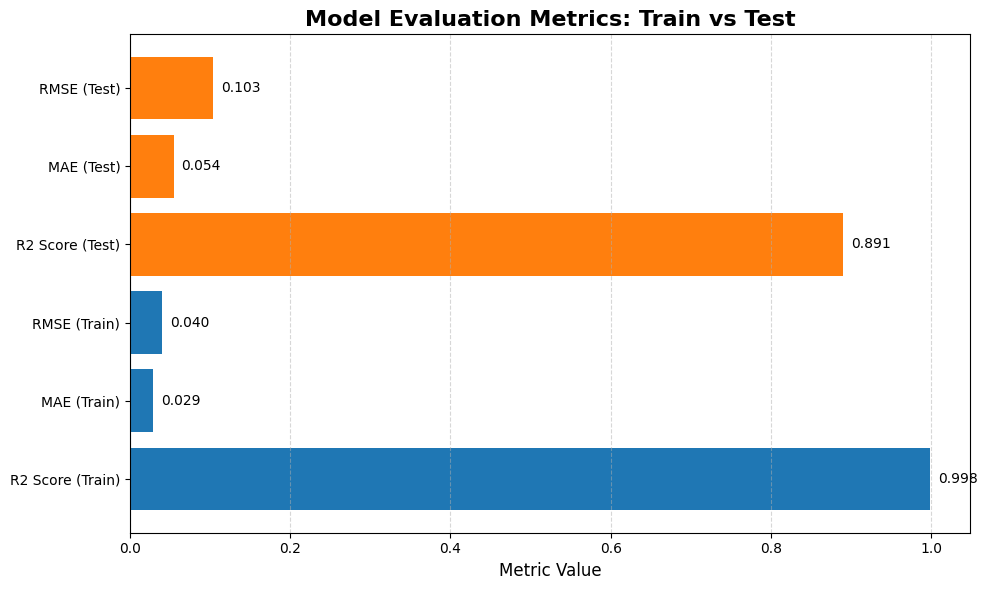

In [ ]:
#predict the model
y_pred_test = model.predict(X_test)
y_train_pred = model.predict(X_train)

#performance metrices
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(train_mse)
test_mse = metrics.mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(test_mse)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_test)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred)))
print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test)))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

# Define the data
metrics_names = ["R2 Score", "MAE", "RMSE"]
train_values = [r2_score(y_train, y_train_pred), metrics.mean_absolute_error(y_train, y_train_pred), rmse_train]
test_values = [r2_score(y_test, y_pred_test), metrics.mean_absolute_error(y_test, y_pred_test), rmse_test]
df = pd.DataFrame({  #create a dataframe
    "Metric": metrics_names * 2,
    "Value": train_values + test_values,
    "Dataset": ["Train"] * 3 + ["Test"] * 3
})

plt.figure(figsize=(10, 6))
colors = ['#1f77b4' if dataset == 'Train' else '#ff7f0e' for dataset in df["Dataset"]]
bars = plt.barh(df["Metric"] + " (" + df["Dataset"] + ")", df["Value"], color=colors)
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.3f}', va='center')

plt.title("Model Evaluation Metrics: Train vs Test", fontsize=16, fontweight='bold')
plt.xlabel("Metric Value", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


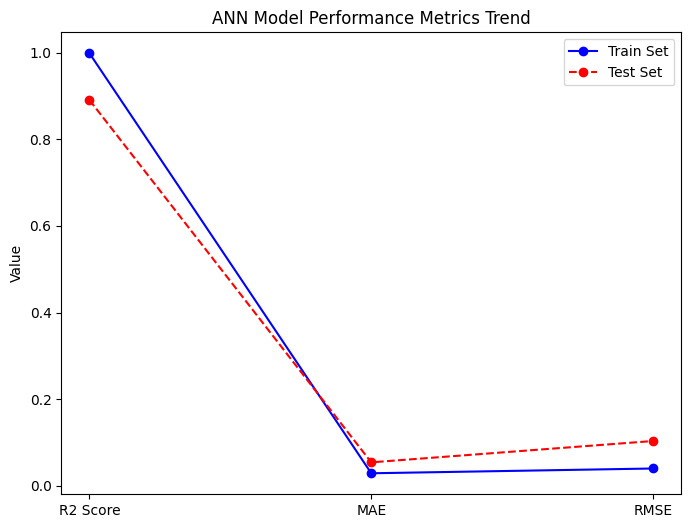

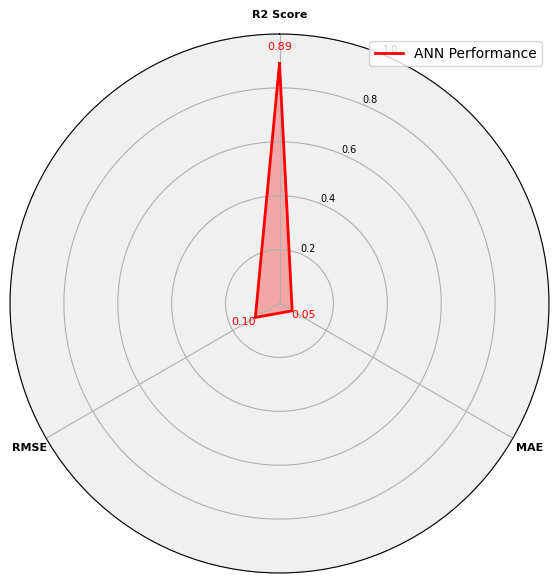

In [ ]:
# Metrics values
metrics_labels = ["R2 Score", "MAE", "RMSE"]
train_values = [r2_train, metrics.mean_absolute_error(y_train, y_train_pred), rmse_train]
test_values = [r2_test, metrics.mean_absolute_error(y_test, y_pred_test), rmse_test]

x = np.arange(len(metrics_labels))  # Label positions

plt.figure(figsize=(8, 6))
plt.plot(metrics_labels, train_values, marker="o", linestyle="-", label="Train Set", color="blue")
plt.plot(metrics_labels, test_values, marker="o", linestyle="--", label="Test Set", color="red")

plt.ylabel("Value")
plt.title("ANN Model Performance Metrics Trend")
plt.legend()
plt.show()

labels = np.array(["R2 Score", "MAE", "RMSE"])
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # Closing the loop

def plot_radar(metrics, title, color):
    values = np.array(list(metrics.values()))
    stats = np.append(values, values[0])  # Closing the radar shape

    plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, polar=True)

    # Styling
    ax.set_facecolor("#f0f0f0")
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Plotting radar chart
    ax.plot(angles, stats, linewidth=2, linestyle='solid', label=title, color=color)
    ax.fill(angles, stats, alpha=0.3, color=color)

    # Labels and details
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=8, fontweight="bold")
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Grid lines
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=7)

    # Annotate points with actual values
    for i, txt in enumerate(stats[:-1]):
        ax.text(angles[i], txt + 0.05, f"{txt:.2f}", color=color, fontsize=8, ha='center')

    #plt.title(title, fontsize=7, fontweight="bold")
    plt.legend()
    plt.show()

metrics_train = {"R2 Score": r2_train, "MAE": metrics.mean_absolute_error(y_train, y_train_pred), "RMSE": rmse_train}
metrics_test = {"R2 Score": r2_test, "MAE": metrics.mean_absolute_error(y_test, y_pred_test), "RMSE": rmse_test}

plot_radar(metrics_test, "ANN Performance", "red")




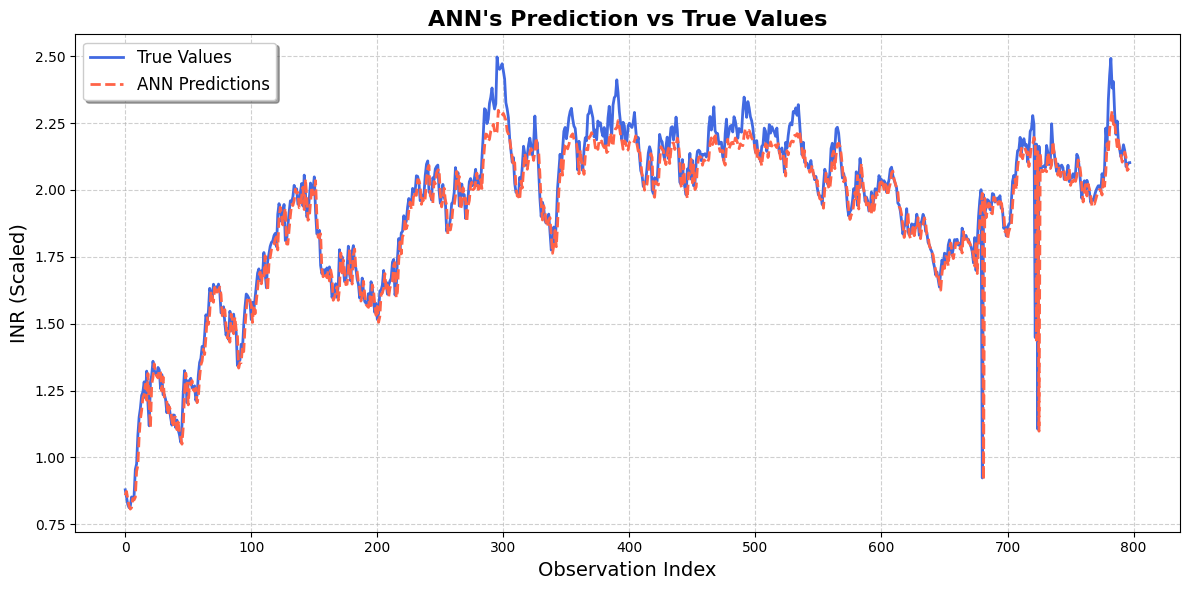

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values', linewidth=2, color='royalblue')
plt.plot(y_pred_test, label='ANN Predictions', linewidth=2, linestyle='--', color='tomato')
plt.title("ANN's Prediction vs True Values", fontsize=16, fontweight='bold')
plt.xlabel('Observation Index', fontsize=14)
plt.ylabel('INR (Scaled)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(frameon=True, shadow=True, fontsize=12)
plt.tight_layout()

In [ ]:
# train the RNN model
model = RNN_model()
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=120, batch_size=32)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1, 1)           │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7573
Epoch 2/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1740
Epoch 3/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 4/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 5/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 6/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 7/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 8/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0020
Epoch 9/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0020
Epoch 10/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 11/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 12/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019
Epoch 13/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018
Epoch 14/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 15/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
The R2 score on the Train set is:	0.998
The  MAE on the Train set is:	0.029
The  RMSE on the Train set is:	0.040
The R2 score on the Test set is:	0.902
The  MAE on the Test set is:	0.047
The  RMSE on the Test set is:	0.098


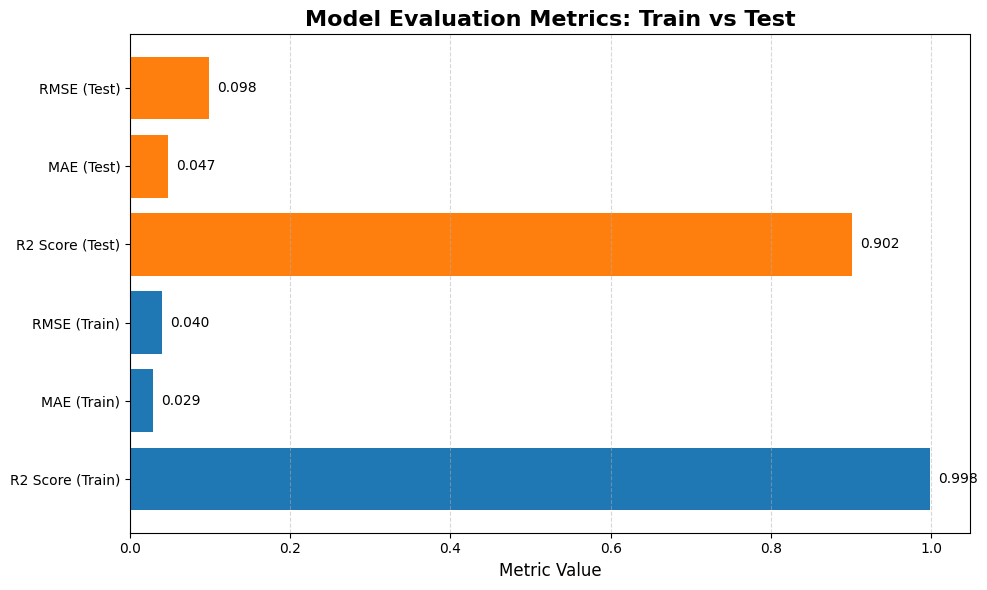

In [ ]:
#predict the model
y_pred_test = model.predict(X_test)
y_train_pred = model.predict(X_train)

y_train_pred = y_train_pred.reshape(-1)
y_train = y_train.reshape(-1)

y_pred_test = y_pred_test.reshape(-1)
y_test = y_test.reshape(-1)

#performance metrices
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(train_mse)
test_mse = metrics.mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(test_mse)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_test)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred)))
print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test)))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

# Define the data
metrics_names = ["R2 Score", "MAE", "RMSE"]
train_values = [r2_score(y_train, y_train_pred), metrics.mean_absolute_error(y_train, y_train_pred), rmse_train]
test_values = [r2_score(y_test, y_pred_test), metrics.mean_absolute_error(y_test, y_pred_test), rmse_test]
df = pd.DataFrame({  #create a dataframe
    "Metric": metrics_names * 2,
    "Value": train_values + test_values,
    "Dataset": ["Train"] * 3 + ["Test"] * 3
})

plt.figure(figsize=(10, 6))
colors = ['#1f77b4' if dataset == 'Train' else '#ff7f0e' for dataset in df["Dataset"]]
bars = plt.barh(df["Metric"] + " (" + df["Dataset"] + ")", df["Value"], color=colors)
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.3f}', va='center')

plt.title("Model Evaluation Metrics: Train vs Test", fontsize=16, fontweight='bold')
plt.xlabel("Metric Value", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


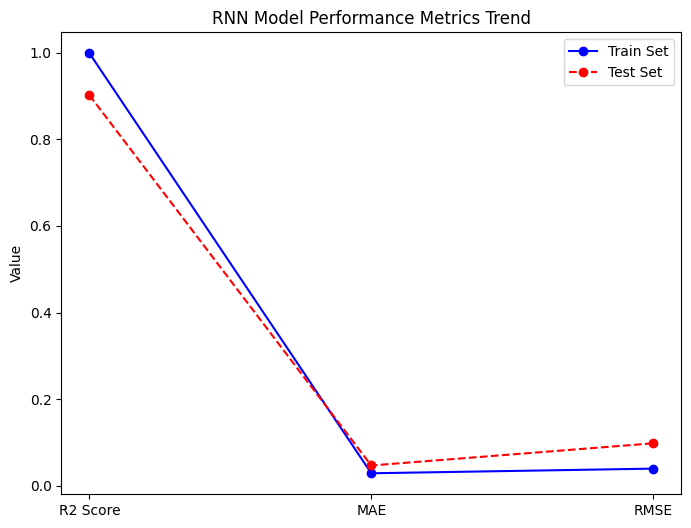

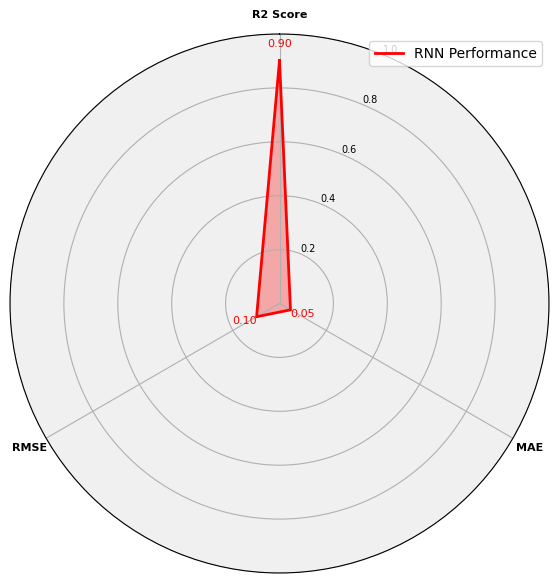

In [ ]:
# Metrics values
metrics_labels = ["R2 Score", "MAE", "RMSE"]
train_values = [r2_train, metrics.mean_absolute_error(y_train, y_train_pred), rmse_train]
test_values = [r2_test, metrics.mean_absolute_error(y_test, y_pred_test), rmse_test]

x = np.arange(len(metrics_labels))  # Label positions

plt.figure(figsize=(8, 6))
plt.plot(metrics_labels, train_values, marker="o", linestyle="-", label="Train Set", color="blue")
plt.plot(metrics_labels, test_values, marker="o", linestyle="--", label="Test Set", color="red")

plt.ylabel("Value")
plt.title("RNN Model Performance Metrics Trend")
plt.legend()
plt.show()

labels = np.array(["R2 Score", "MAE", "RMSE"])
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # Closing the loop

def plot_radar(metrics, title, color):
    values = np.array(list(metrics.values()))
    stats = np.append(values, values[0])  # Closing the radar shape

    plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, polar=True)

    # Styling
    ax.set_facecolor("#f0f0f0")
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Plotting radar chart
    ax.plot(angles, stats, linewidth=2, linestyle='solid', label=title, color=color)
    ax.fill(angles, stats, alpha=0.3, color=color)

    # Labels and details
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=8, fontweight="bold")
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Grid lines
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=7)

    # Annotate points with actual values
    for i, txt in enumerate(stats[:-1]):
        ax.text(angles[i], txt + 0.05, f"{txt:.2f}", color=color, fontsize=8, ha='center')

    #plt.title(title, fontsize=7, fontweight="bold")
    plt.legend()
    plt.show()

metrics_train = {"R2 Score": r2_train, "MAE": metrics.mean_absolute_error(y_train, y_train_pred), "RMSE": rmse_train}
metrics_test = {"R2 Score": r2_test, "MAE": metrics.mean_absolute_error(y_test, y_pred_test), "RMSE": rmse_test}

plot_radar(metrics_test, "RNN Performance", "red")




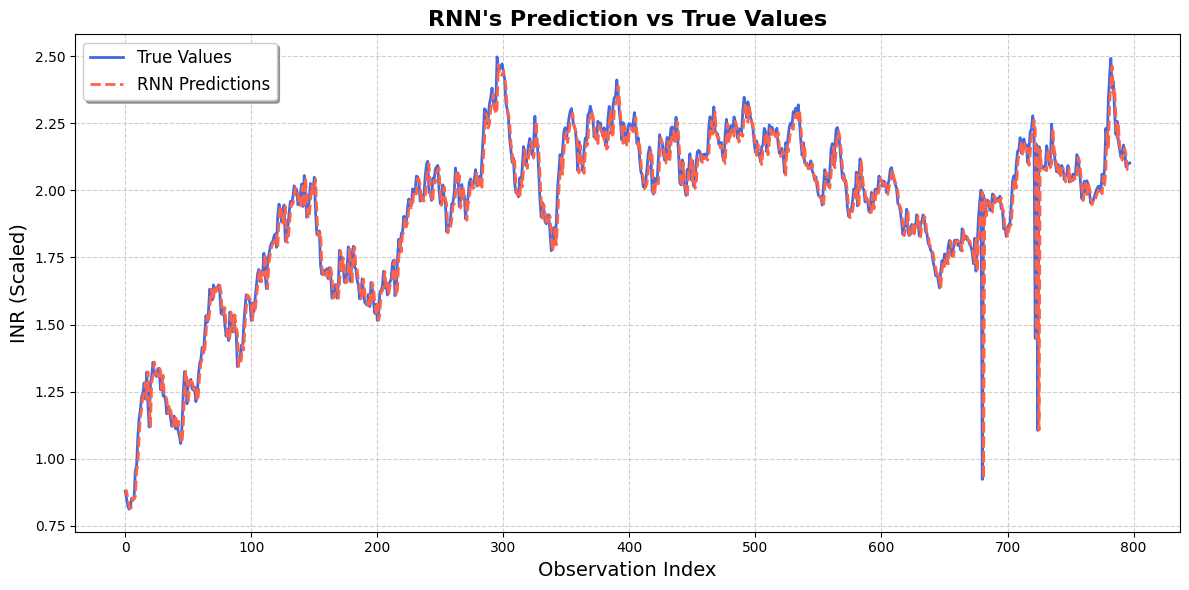

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values', linewidth=2, color='royalblue')
plt.plot(y_pred_test, label='RNN Predictions', linewidth=2, linestyle='--', color='tomato')
plt.title("RNN's Prediction vs True Values", fontsize=16, fontweight='bold')
plt.xlabel('Observation Index', fontsize=14)
plt.ylabel('INR (Scaled)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(frameon=True, shadow=True, fontsize=12)
plt.tight_layout()

In [ ]:
# train the LSTM model
model = LSTM_model(X_train)
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=120, batch_size=32)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 1, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6413
Epoch 2/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0140
Epoch 3/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0145
Epoch 4/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135
Epoch 5/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130
Epoch 6/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0129
Epoch 7/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0126
Epoch 8/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0124
Epoch 9/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0113
Epoch 10/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0118
Epoch 11/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124
Epoch 12/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0109
Epoch 13/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124
Epoch 14/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0118
Epoch 15/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
The R2 score on the Train set is:	0.998
The  MAE on the Train set is:	0.034
The  RMSE on the Train set is:	0.045
The R2 score on the Test set is:	0.884
The  MAE on the Test set is:	0.063
The  RMSE on the Test set is:	0.107


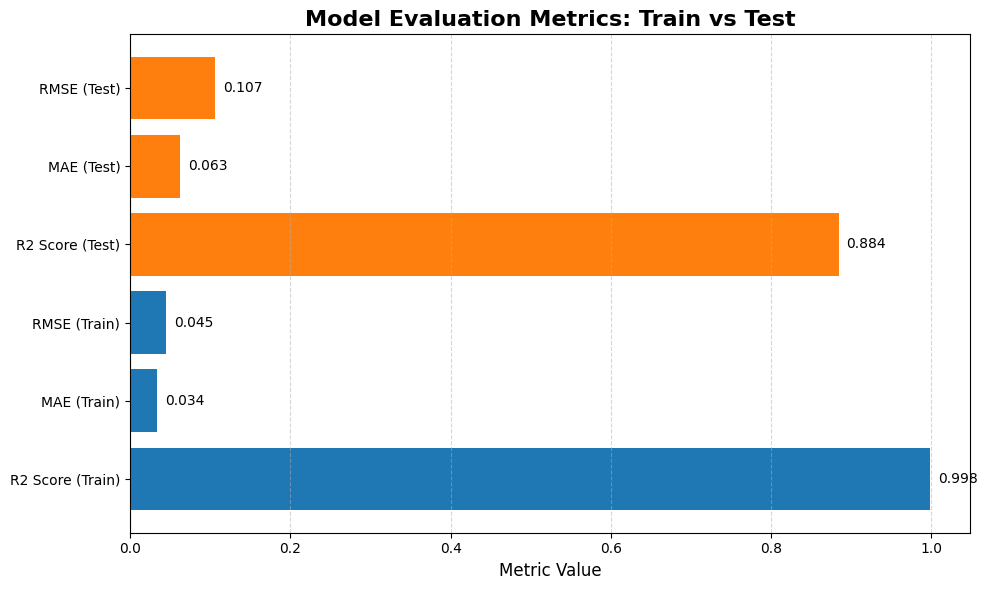

In [ ]:
#predict the model
y_pred_test = model.predict(X_test)
y_train_pred = model.predict(X_train)

#performance metrices
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(train_mse)
test_mse = metrics.mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(test_mse)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_test)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred)))
print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test)))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

# Define the data
metrics_names = ["R2 Score", "MAE", "RMSE"]
train_values = [r2_score(y_train, y_train_pred), metrics.mean_absolute_error(y_train, y_train_pred), rmse_train]
test_values = [r2_score(y_test, y_pred_test), metrics.mean_absolute_error(y_test, y_pred_test), rmse_test]
df = pd.DataFrame({  #create a dataframe
    "Metric": metrics_names * 2,
    "Value": train_values + test_values,
    "Dataset": ["Train"] * 3 + ["Test"] * 3
})

plt.figure(figsize=(10, 6))
colors = ['#1f77b4' if dataset == 'Train' else '#ff7f0e' for dataset in df["Dataset"]]
bars = plt.barh(df["Metric"] + " (" + df["Dataset"] + ")", df["Value"], color=colors)
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.3f}', va='center')

plt.title("Model Evaluation Metrics: Train vs Test", fontsize=16, fontweight='bold')
plt.xlabel("Metric Value", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


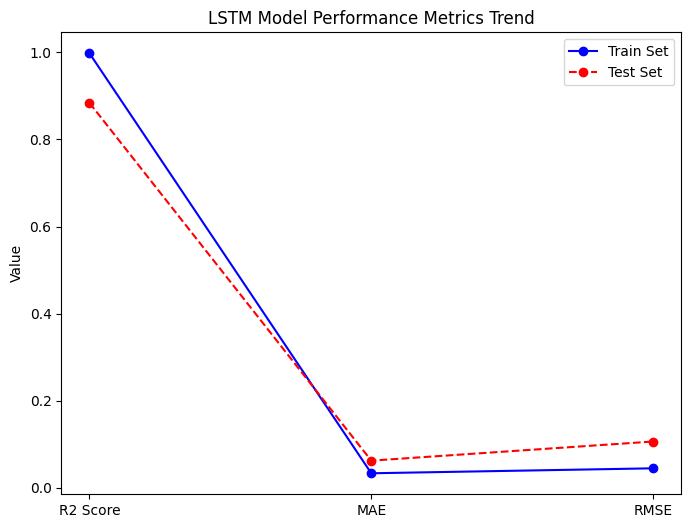

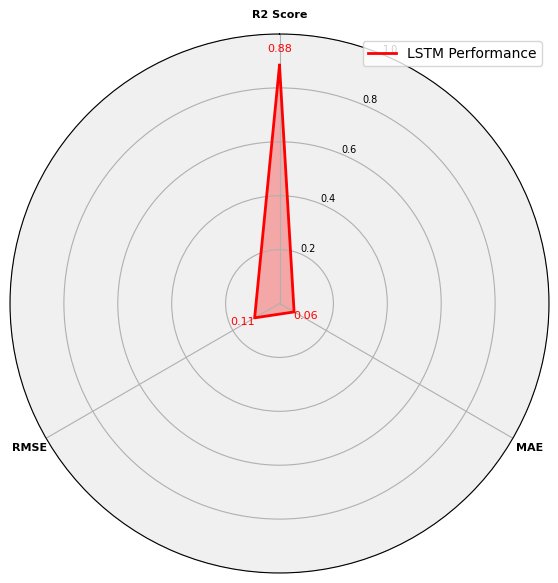

In [ ]:
# Metrics values
metrics_labels = ["R2 Score", "MAE", "RMSE"]
train_values = [r2_train, metrics.mean_absolute_error(y_train, y_train_pred), rmse_train]
test_values = [r2_test, metrics.mean_absolute_error(y_test, y_pred_test), rmse_test]

x = np.arange(len(metrics_labels))  # Label positions

plt.figure(figsize=(8, 6))
plt.plot(metrics_labels, train_values, marker="o", linestyle="-", label="Train Set", color="blue")
plt.plot(metrics_labels, test_values, marker="o", linestyle="--", label="Test Set", color="red")

plt.ylabel("Value")
plt.title("LSTM Model Performance Metrics Trend")
plt.legend()
plt.show()

labels = np.array(["R2 Score", "MAE", "RMSE"])
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # Closing the loop

def plot_radar(metrics, title, color):
    values = np.array(list(metrics.values()))
    stats = np.append(values, values[0])  # Closing the radar shape

    plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, polar=True)

    # Styling
    ax.set_facecolor("#f0f0f0")
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Plotting radar chart
    ax.plot(angles, stats, linewidth=2, linestyle='solid', label=title, color=color)
    ax.fill(angles, stats, alpha=0.3, color=color)

    # Labels and details
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=8, fontweight="bold")
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Grid lines
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=7)

    # Annotate points with actual values
    for i, txt in enumerate(stats[:-1]):
        ax.text(angles[i], txt + 0.05, f"{txt:.2f}", color=color, fontsize=8, ha='center')

    #plt.title(title, fontsize=7, fontweight="bold")
    plt.legend()
    plt.show()

metrics_train = {"R2 Score": r2_train, "MAE": metrics.mean_absolute_error(y_train, y_train_pred), "RMSE": rmse_train}
metrics_test = {"R2 Score": r2_test, "MAE": metrics.mean_absolute_error(y_test, y_pred_test), "RMSE": rmse_test}

plot_radar(metrics_test, "LSTM Performance", "red")




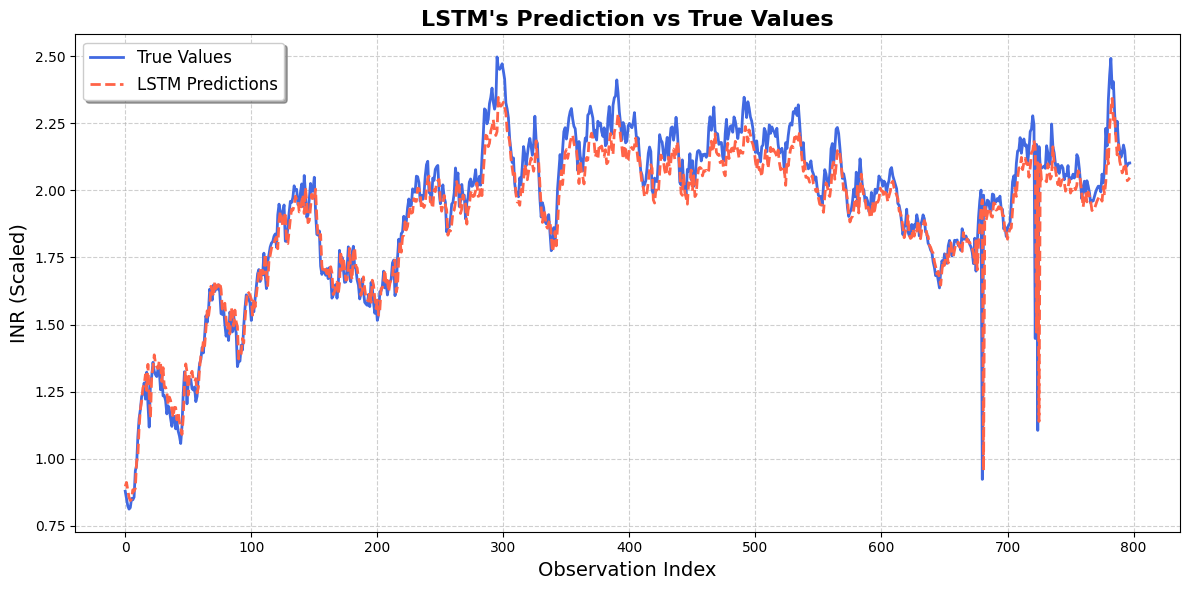

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values', linewidth=2, color='royalblue')
plt.plot(y_pred_test, label='LSTM Predictions', linewidth=2, linestyle='--', color='tomato')
plt.title("LSTM's Prediction vs True Values", fontsize=16, fontweight='bold')
plt.xlabel('Observation Index', fontsize=14)
plt.ylabel('INR (Scaled)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(frameon=True, shadow=True, fontsize=12)
plt.tight_layout()

In [ ]:
# train the GRU model
model = GRU_model()
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=120, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 7)              │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218 (872.00 B)

 Trainable params: 218 (872.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.5263
Epoch 2/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0279
Epoch 3/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2920
Epoch 4/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0469
Epoch 5/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073
Epoch 6/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045
Epoch 7/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043
Epoch 8/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040
Epoch 9/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0040
Epoch 10/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036
Epoch 11/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0036
Epoch 12/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035
Epoch 13/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034
Epoch 14/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032
Epoch 15/120
100/100 ━━━━━━━━━━━━━━━━━━━━ 0

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
The R2 score on the Train set is:	0.998
The  MAE on the Train set is:	0.029
The  RMSE on the Train set is:	0.040
The R2 score on the Test set is:	0.895
The  MAE on the Test set is:	0.053
The  RMSE on the Test set is:	0.101


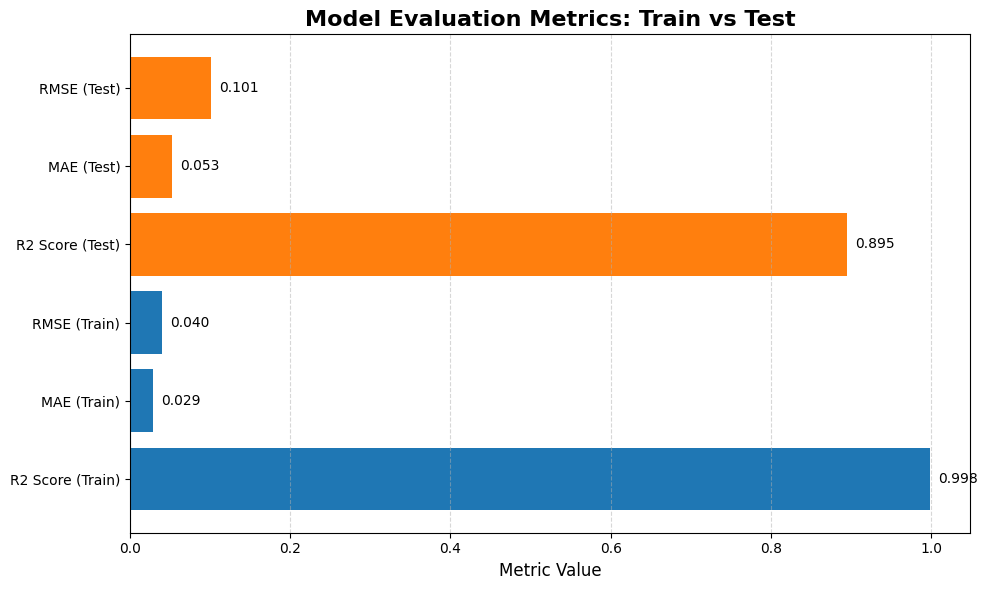

In [ ]:
#predict the model
y_pred_test = model.predict(X_test)
y_train_pred = model.predict(X_train)

#performance metrices
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(train_mse)
test_mse = metrics.mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(test_mse)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_test)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred)))
print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test)))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

# Define the data
metrics_names = ["R2 Score", "MAE", "RMSE"]
train_values = [r2_score(y_train, y_train_pred), metrics.mean_absolute_error(y_train, y_train_pred), rmse_train]
test_values = [r2_score(y_test, y_pred_test), metrics.mean_absolute_error(y_test, y_pred_test), rmse_test]
df = pd.DataFrame({  #create a dataframe
    "Metric": metrics_names * 2,
    "Value": train_values + test_values,
    "Dataset": ["Train"] * 3 + ["Test"] * 3
})

plt.figure(figsize=(10, 6))
colors = ['#1f77b4' if dataset == 'Train' else '#ff7f0e' for dataset in df["Dataset"]]
bars = plt.barh(df["Metric"] + " (" + df["Dataset"] + ")", df["Value"], color=colors)
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.3f}', va='center')

plt.title("Model Evaluation Metrics: Train vs Test", fontsize=16, fontweight='bold')
plt.xlabel("Metric Value", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


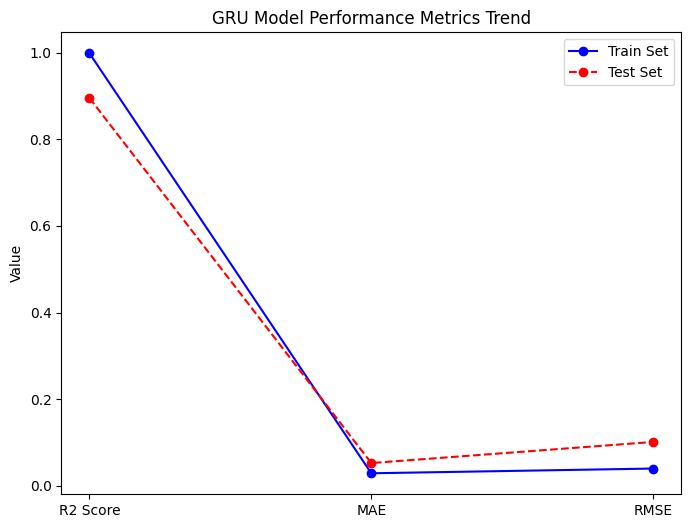

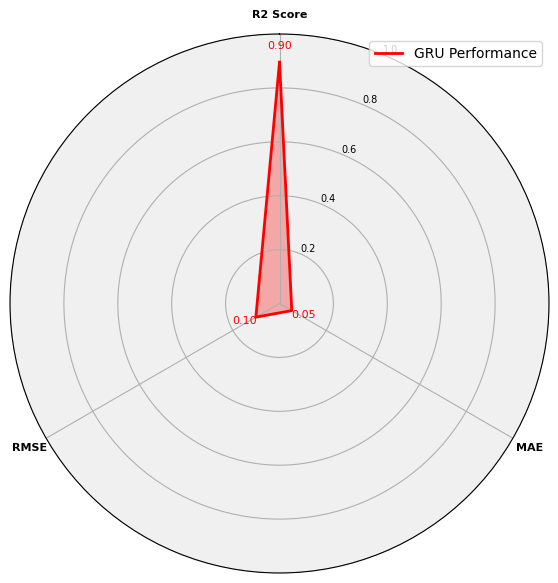

In [ ]:
# Metrics values
metrics_labels = ["R2 Score", "MAE", "RMSE"]
train_values = [r2_train, metrics.mean_absolute_error(y_train, y_train_pred), rmse_train]
test_values = [r2_test, metrics.mean_absolute_error(y_test, y_pred_test), rmse_test]

x = np.arange(len(metrics_labels))  # Label positions

plt.figure(figsize=(8, 6))
plt.plot(metrics_labels, train_values, marker="o", linestyle="-", label="Train Set", color="blue")
plt.plot(metrics_labels, test_values, marker="o", linestyle="--", label="Test Set", color="red")

plt.ylabel("Value")
plt.title("GRU Model Performance Metrics Trend")
plt.legend()
plt.show()

labels = np.array(["R2 Score", "MAE", "RMSE"])
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # Closing the loop

def plot_radar(metrics, title, color):
    values = np.array(list(metrics.values()))
    stats = np.append(values, values[0])  # Closing the radar shape

    plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, polar=True)

    # Styling
    ax.set_facecolor("#f0f0f0")
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Plotting radar chart
    ax.plot(angles, stats, linewidth=2, linestyle='solid', label=title, color=color)
    ax.fill(angles, stats, alpha=0.3, color=color)

    # Labels and details
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=8, fontweight="bold")
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Grid lines
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=7)

    # Annotate points with actual values
    for i, txt in enumerate(stats[:-1]):
        ax.text(angles[i], txt + 0.05, f"{txt:.2f}", color=color, fontsize=8, ha='center')

    #plt.title(title, fontsize=7, fontweight="bold")
    plt.legend()
    plt.show()

metrics_train = {"R2 Score": r2_train, "MAE": metrics.mean_absolute_error(y_train, y_train_pred), "RMSE": rmse_train}
metrics_test = {"R2 Score": r2_test, "MAE": metrics.mean_absolute_error(y_test, y_pred_test), "RMSE": rmse_test}

plot_radar(metrics_test, "GRU Performance", "red")




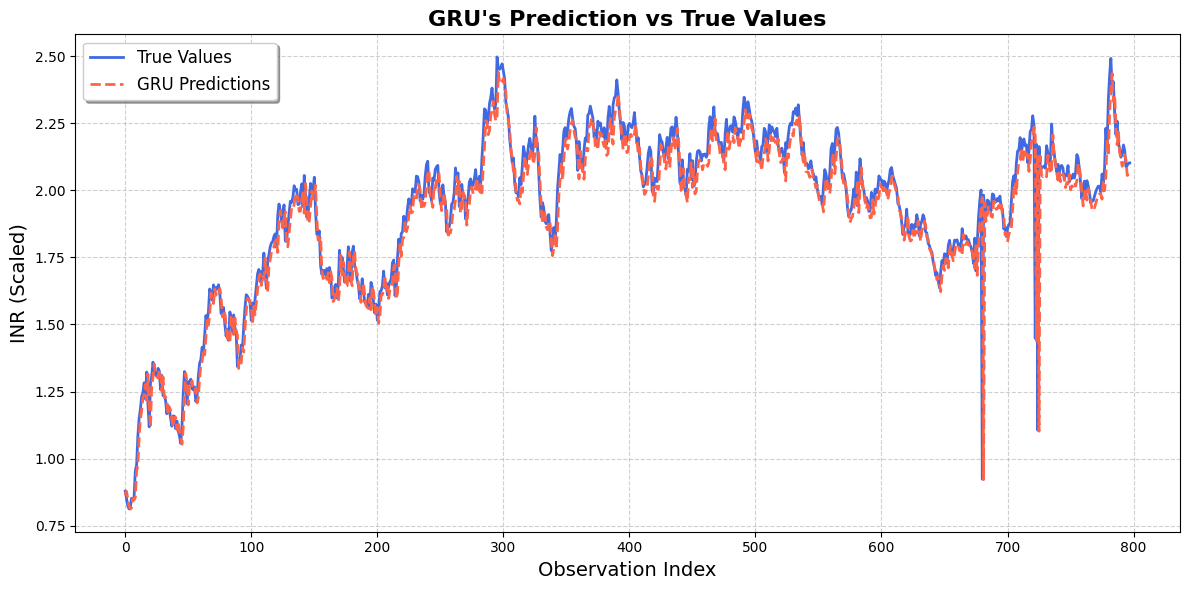

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values', linewidth=2, color='royalblue')
plt.plot(y_pred_test, label='GRU Predictions', linewidth=2, linestyle='--', color='tomato')
plt.title("GRU's Prediction vs True Values", fontsize=16, fontweight='bold')
plt.xlabel('Observation Index', fontsize=14)
plt.ylabel('INR (Scaled)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(frameon=True, shadow=True, fontsize=12)
plt.tight_layout()